In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pyflann import *
import pandas as pd
import datetime

In [2]:
# 将工作环境调整至/data下, 获得水平分割完成的图像
path1 = os.path.abspath('..')
path2 = path1.replace('\\', '/')
os.chdir(path2 + '/data/')

In [3]:
target = cv2.imread('planogram_segmented/IMG_0114_2.jpg', 1)
template = cv2.imread('template/template.png', 1)

In [4]:
def get_patches_vector(image: np.ndarray, patch_size: int = 3) -> np.ndarray:
    print(datetime.datetime.now())
    print('Start getting vector.')
    image_x = image.shape[0]
    image_y = image.shape[1]

    padding = int(patch_size / 2)
    img = cv2.copyMakeBorder(image, padding, padding, padding, padding
                             , cv2.BORDER_REPLICATE)
    patches_vector = np.zeros(shape=(image_x * image_y, 3 * patch_size * patch_size))
    for x in range(0, image_x):
        for y in range(0, image_y):
            patches_vector[x * image_y + y] = img[x:x + patch_size, y:y + patch_size].reshape(
                3 * patch_size * patch_size)

    print(datetime.datetime.now())
    print("Vector got!")
    return patches_vector

In [5]:
def gray_image_show(img):
    plt.figure(figsize=(10, 12))
    plt.imshow(img, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()

def color_image_show(img):
    plt.figure(figsize=(10, 12))
    image_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_show, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()

In [6]:
target_sp = cv2.resize(target, None, fx=0.4, fy=0.4, interpolation=cv2.INTER_CUBIC)
template_sp = cv2.resize(template, None, fx=0.4, fy=0.4, interpolation=cv2.INTER_CUBIC)

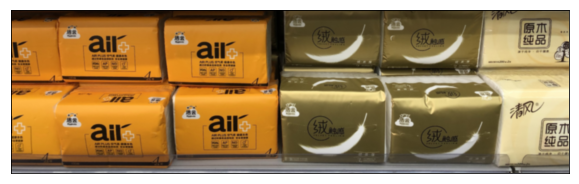

In [7]:
color_image_show(target_sp)

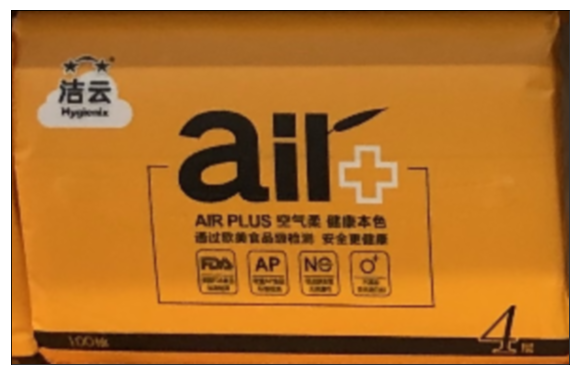

In [22]:
color_image_show(template_sp)

In [8]:
target_vector = get_patches_vector(target_sp)
template_vector = get_patches_vector(template_sp)

2019-04-09 22:57:43.638835
Start getting vector.
2019-04-09 22:57:45.773725
Vector got!
2019-04-09 22:57:45.775721
Start getting vector.
2019-04-09 22:57:45.983179
Vector got!


In [9]:
flann = FLANN()

In [10]:
params = flann.build_index(template_vector, algorithm='kmeans', trees=1)

In [11]:
result, dists = flann.nn_index(target_vector, 1, checks=params['checks'])

In [12]:
nn_counts = pd.Series(result).value_counts()

In [13]:
iwu_matrix = np.zeros(shape=(target_sp.shape[0], target_sp.shape[1]))
for i in range(len(result)):
    iwu_matrix[int(i / target_sp.shape[1]), i % target_sp.shape[1]] = nn_counts[result[i]]

In [14]:
iwu_e_matrix = np.exp(-iwu_matrix)

In [15]:
iwu_e_matrix

array([[5.56334737e-161, 5.56334737e-161, 5.56334737e-161, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [6.44741635e-102, 6.44741635e-102, 2.22736356e-039, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [1.18088550e-103, 1.18088550e-103, 1.18088550e-103, ...,
        0.00000000e+000, 9.46262947e-057, 1.20753679e-189],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        5.24582356e-293, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 3.20997959e-103, 3.20997959e-103, ...,
        2.63957030e-066, 0.00000000e+000, 0.00000000e+000]])

In [18]:
X = target_sp.shape[0]
Y = target_sp.shape[1]
x = template_sp.shape[0]
y = template_sp.shape[1]
window_score_matrix = np.zeros(shape=(X - x + 1, Y - y + 1))
for m in range(window_score_matrix.shape[0]):
    for n in range(window_score_matrix.shape[1]):
        window_score_matrix[m, n] = np.sum(iwu_e_matrix[m:m + x, n:n + y])

In [19]:
window_score_matrix.shape

(284, 1318)

In [20]:
import seaborn as sns

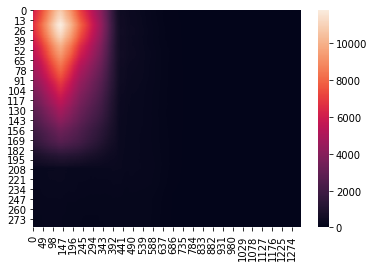

In [21]:
sns.heatmap(window_score_matrix)